<a href="https://colab.research.google.com/github/nielsrolf/GAN-TUBerlin/blob/master/colab_gan_that_imports_from_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Clone or update the repo, then import it, get the data and plot it

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
11493376/11490434 [==============================] - 0s 0us/step


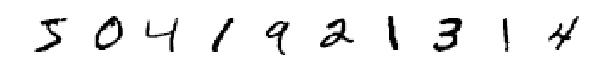

In [2]:
%load_ext autoreload
%autoreload 2

from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)
PROJ = "My Drive/gan_tu" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)


regular_training = False
unconnected_support_prior = False
train_d_more_often = False

from importlib.machinery import SourceFileLoader
gan = SourceFileLoader('gan', join(PROJECT_PATH, 'gan.py')).load_module()
callbacks = SourceFileLoader('callbacks', join(PROJECT_PATH, 'callbacks.py')).load_module()


GradientInverser = gan.GradientInverser
DCGAN = gan.DCGAN
Uniform = gan.Uniform
Unconnected = gan.Unconnected
AutoencodingGAN = gan.AutoencodingGAN

OverfittingCallback = callbacks.OverfittingCallback   
InverseDistributionCallback = callbacks.InverseDistributionCallback
EvolvingImageCallback = callbacks.EvolvingImageCallback
InterpolationCallback = callbacks.InterpolationCallback
show = callbacks.show


from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import sys
import numpy as np

# Load the dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_test = X_test / 127.5 - 1.

X_train = np.reshape(X_train, [-1, 28, 28, 1])
X_test = np.reshape(X_test, [-1, 28, 28, 1])

X_train.shape
callbacks.show(X_train[:10])

# transform it to one hot encoding
Y_train = np.eye(10)[Y_train]
Y_test = np.eye(10)[Y_test]


# Regular Training

In [0]:
if regular_training:
    dcgan = gan.DCGAN(gan.Uniform(100))



    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

# Unconnected Support Prior

In [0]:
if unconnected_support_prior:
    dcgan = gan.DCGAN(gan.Unconnected(100))


    pmetric = callbacks.PMetrics(dcgan, X_test[:1000])
    period = 10
    train_callbacks = [
        (callbacks.EvolvingImageCallback(dcgan).plot, period),
        (callbacks.InterpolationCallback(dcgan).plot, period),
        (pmetric.track, 1),
        (pmetric.plot, period),
        (lambda: dcgan.save('models_mnist_u'), period),
        (callbacks.InverseDistributionCallback(dcgan, X_train[:100], "X_train").plot, period),
        (callbacks.InverseDistributionCallback(dcgan, X_test[:100], "X_test").plot, period),
        (ModeCollapseObserver(dcgan, get_mnist_predictor()), period)
    ]

    dcgan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

The assumption is wrong.

# Autoencoding GAN

We can combine the GAN with an Autoencoder, where the generator is used as decoder. This can either be done by only training an additional encoder, or by training the generator to optimize both objectives, that of the autoencoder and that of the GAN setup.

We then have two different ways to invert a GAN, which we can compare. It will show that both methods yield quite different encodings, however yield in similar decoded images. This indicates that there are areas in z space that are all mapped to similar output in x space. Applying the difference of two encodings of the same image to another image shows, that the effect is here much bigger, which shows that the encodings don't differ in a dimension or length that the generator is in general invariant to, but that at different areas of the latent space, certain directions have a small gradient with respect to G.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train reconstruction


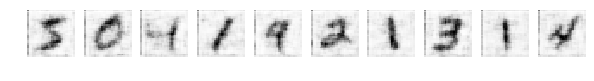

Original Train


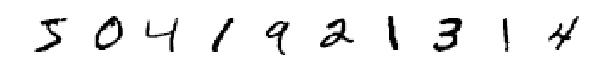

Test reconstruction


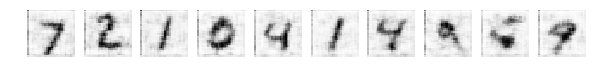

Original Test


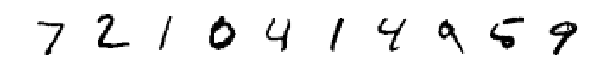

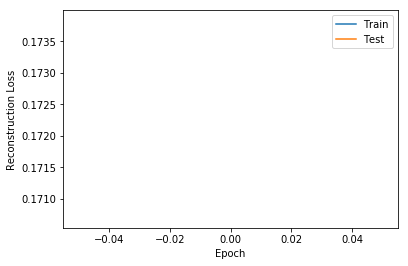

Train reconstruction


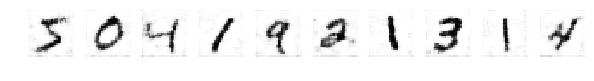

Original Train


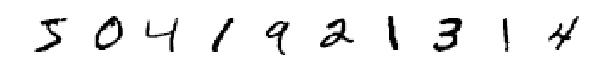

Test reconstruction


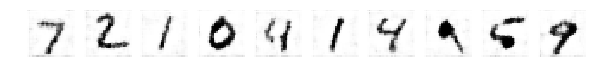

Original Test


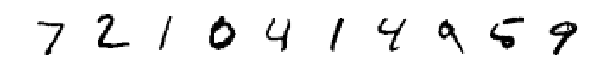

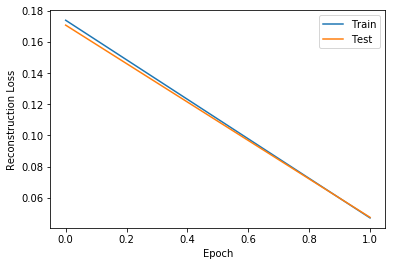

Train reconstruction


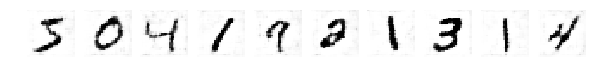

Original Train


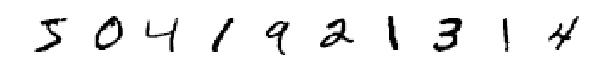

Test reconstruction


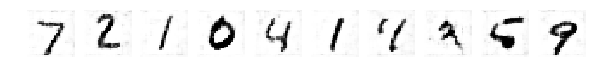

Original Test


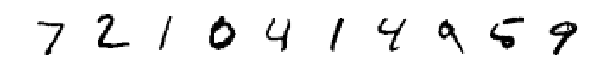

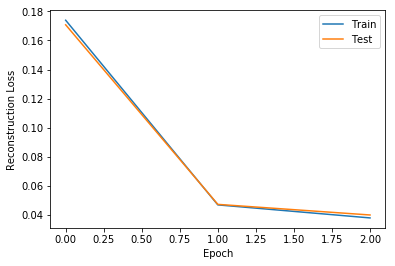

Train reconstruction


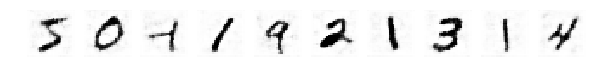

Original Train


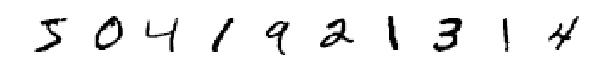

Test reconstruction


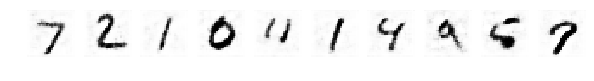

Original Test


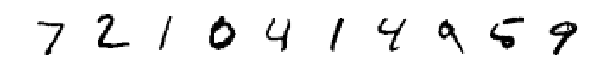

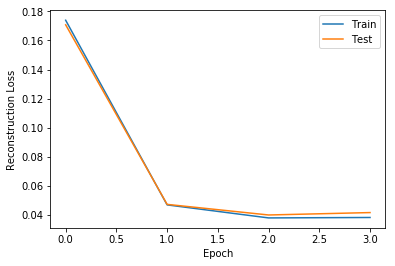

Train reconstruction


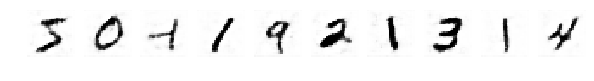

Original Train


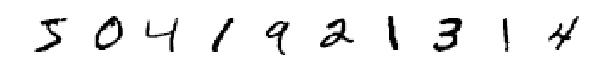

Test reconstruction


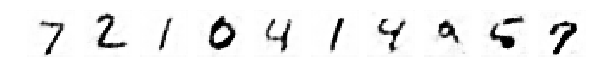

Original Test


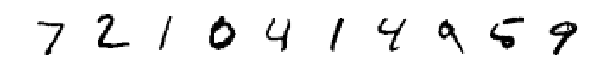

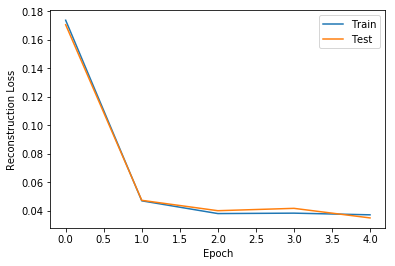

Train reconstruction


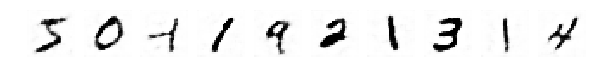

Original Train


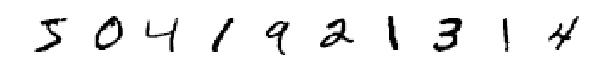

Test reconstruction


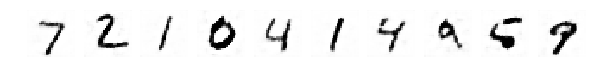

Original Test


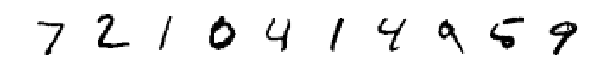

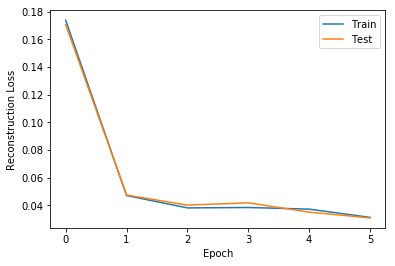

Train reconstruction


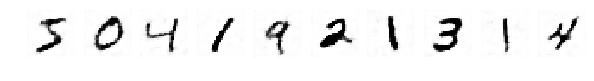

Original Train


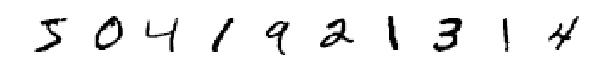

Test reconstruction


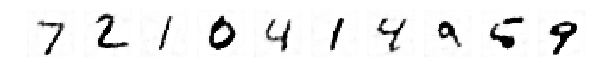

Original Test


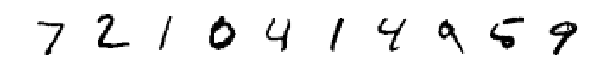

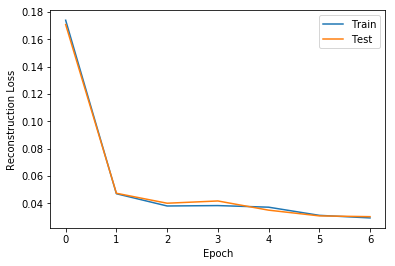

Train reconstruction


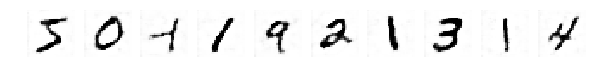

Original Train


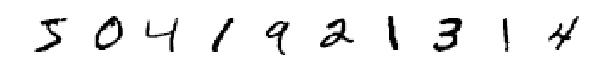

Test reconstruction


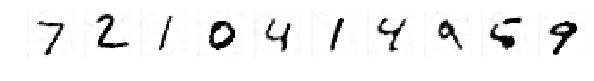

Original Test


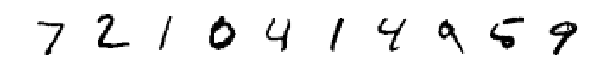

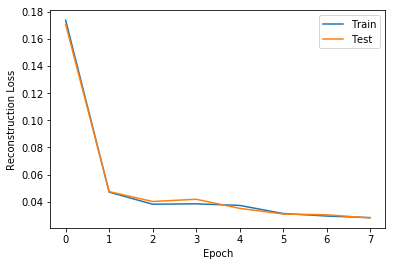

KeyboardInterrupt: ignored

In [0]:
dcgan = DCGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(dcgan, X_train[:100], X_test[:100])
train_callbacks = [
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1)
]

dcgan.train(X_train[:1280], epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

## Train additional encoder without changing GAN training

In [0]:
aegan = AutoencodingGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1)
]

aegan.train(X_train, epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=5)

## Include generator in Aeutoencder training

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


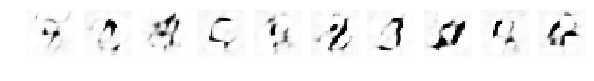

Train reconstruction


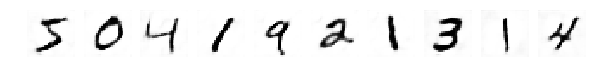

Original Train


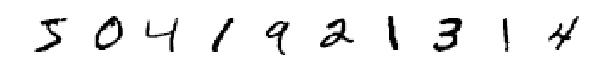

Test reconstruction


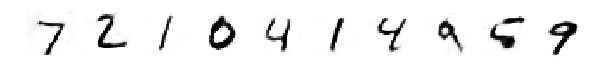

Original Test


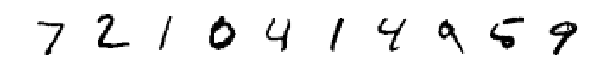

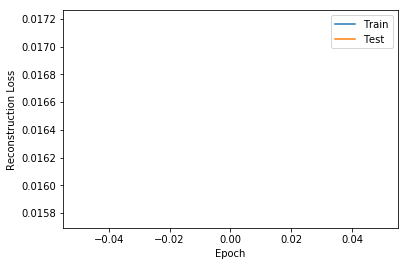

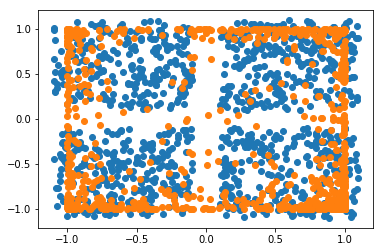

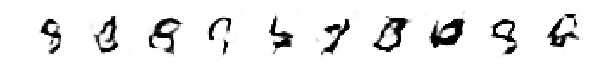

Train reconstruction


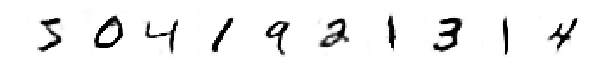

Original Train


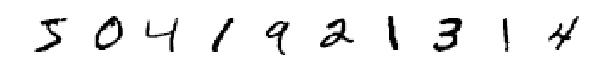

Test reconstruction


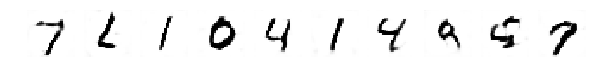

Original Test


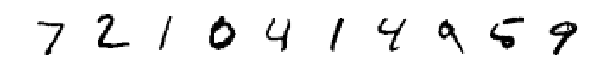

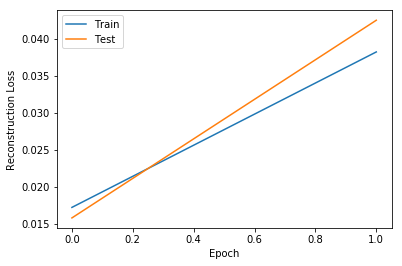

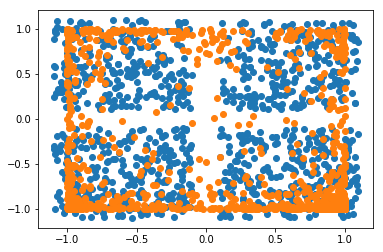

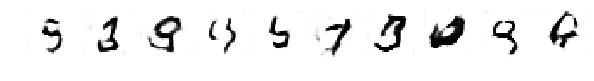

Train reconstruction


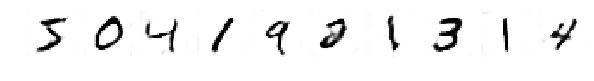

Original Train


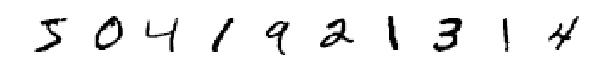

Test reconstruction


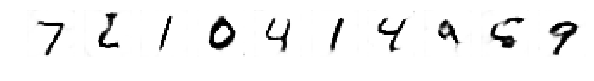

Original Test


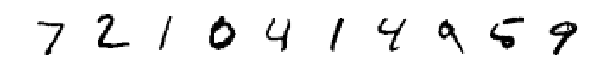

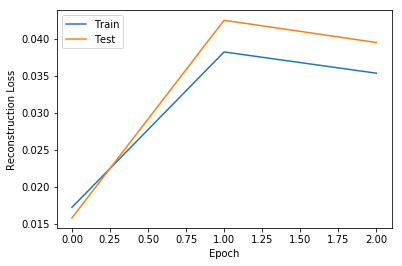

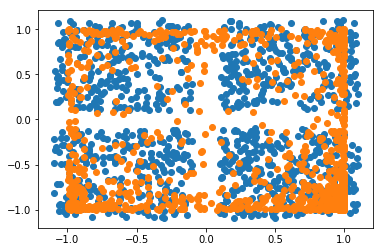

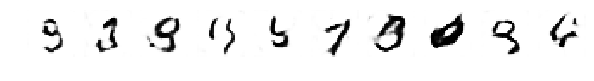

Train reconstruction


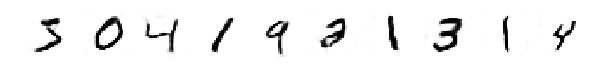

Original Train


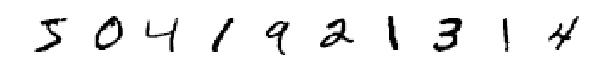

Test reconstruction


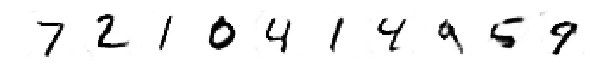

Original Test


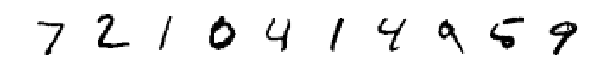

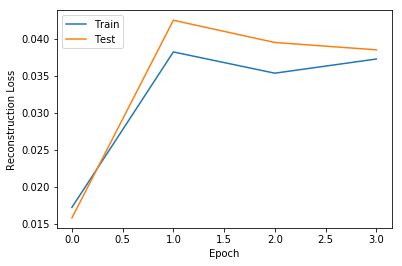

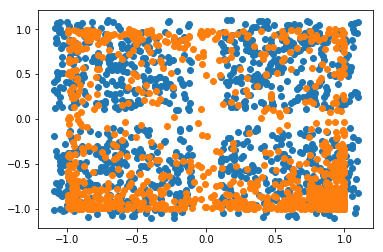

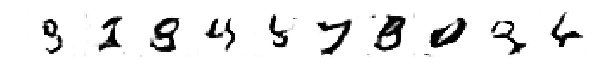

Train reconstruction


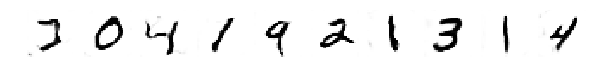

Original Train


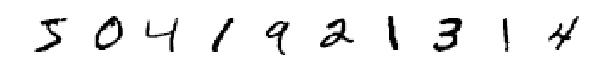

Test reconstruction


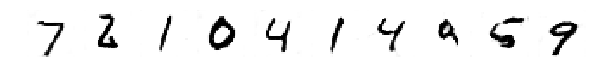

Original Test


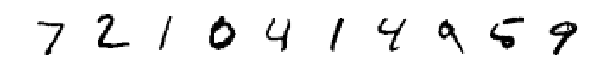

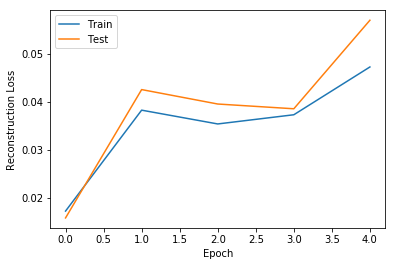

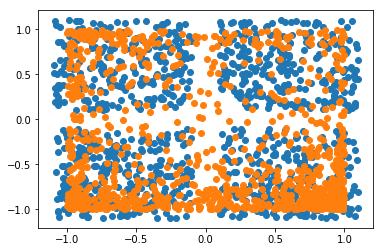

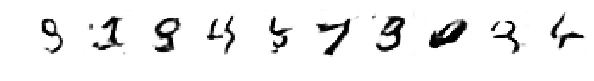

Train reconstruction


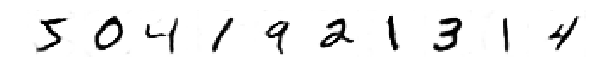

Original Train


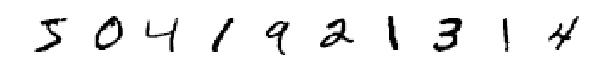

Test reconstruction


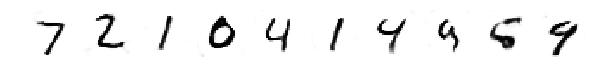

Original Test


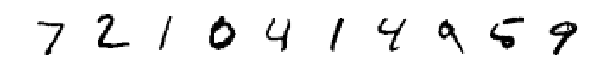

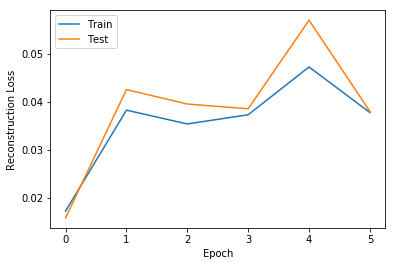

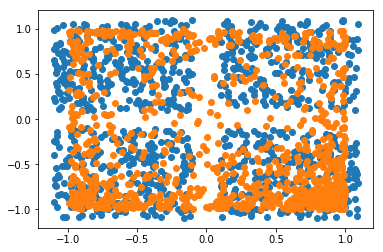

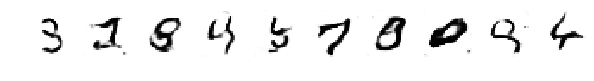

Train reconstruction


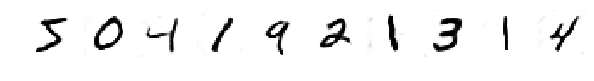

Original Train


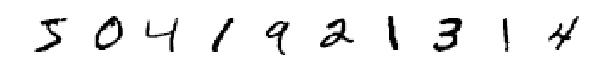

Test reconstruction


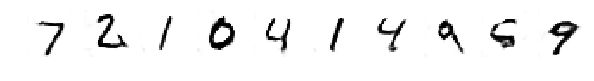

Original Test


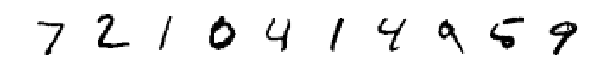

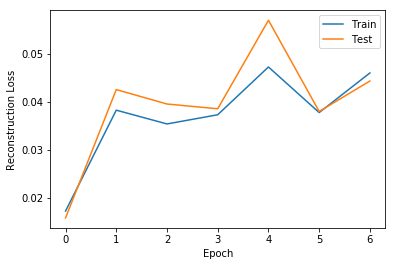

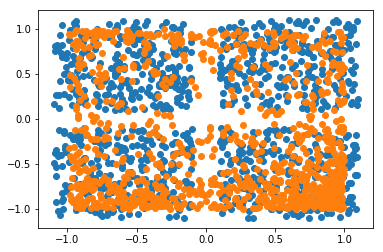

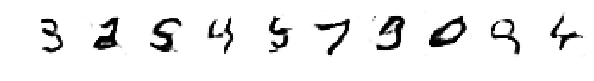

Train reconstruction


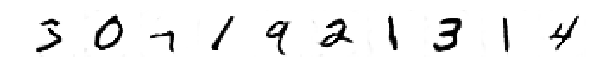

Original Train


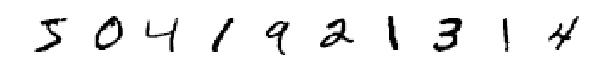

Test reconstruction


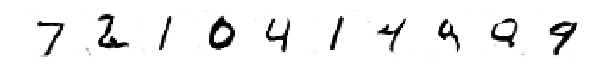

Original Test


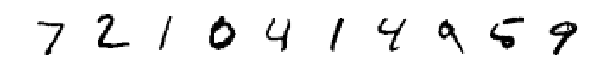

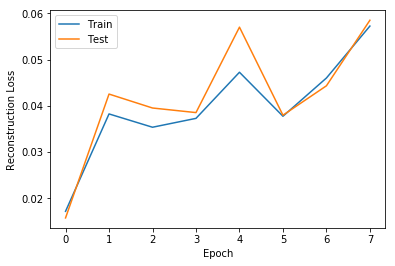

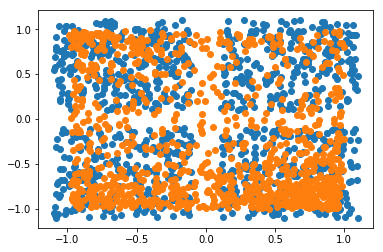

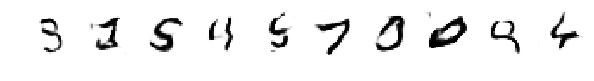

Train reconstruction


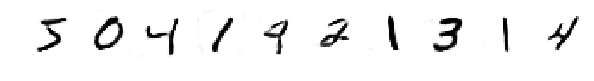

Original Train


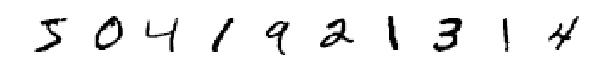

Test reconstruction


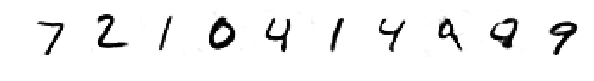

Original Test


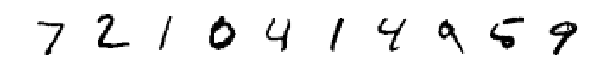

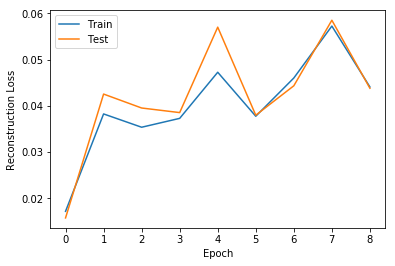

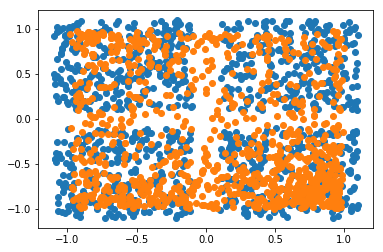

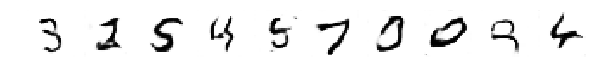

Train reconstruction


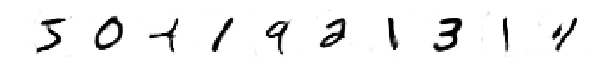

Original Train


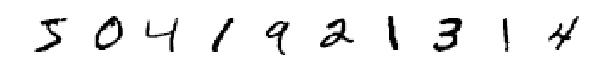

Test reconstruction


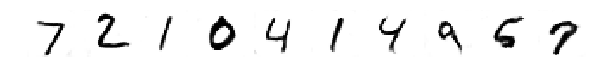

Original Test


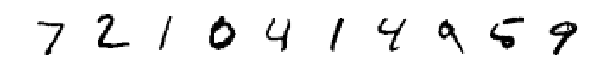

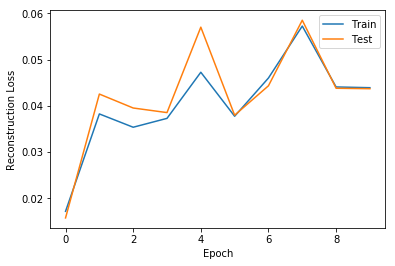

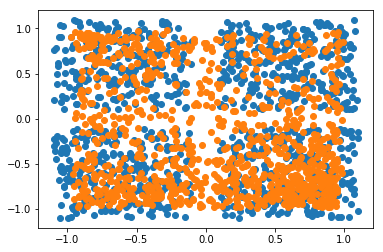

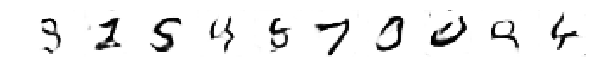

Train reconstruction


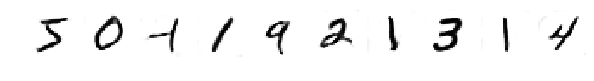

Original Train


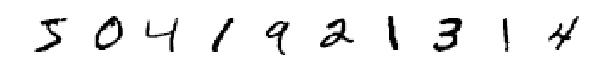

Test reconstruction


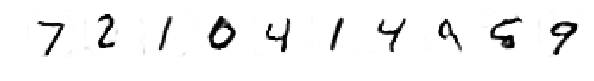

Original Test


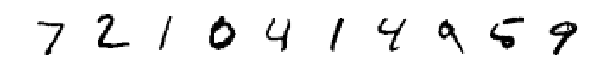

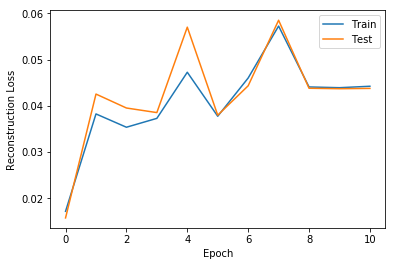

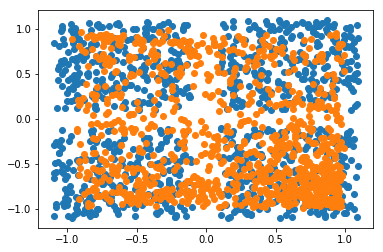

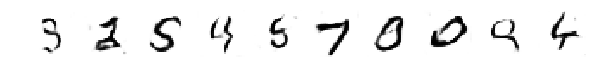

Train reconstruction


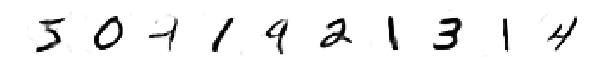

Original Train


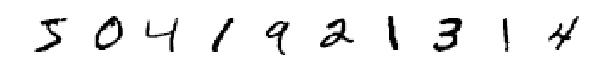

Test reconstruction


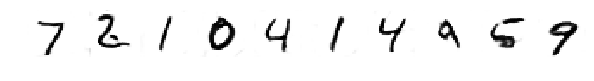

Original Test


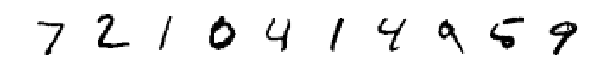

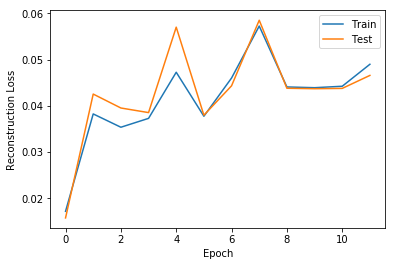

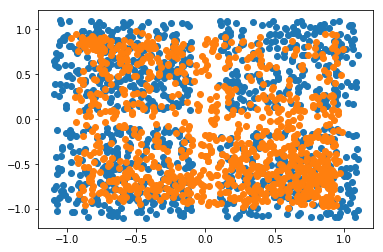

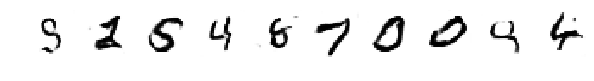

Train reconstruction


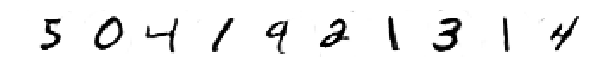

Original Train


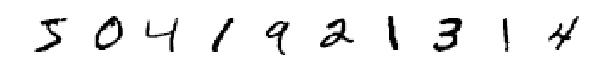

Test reconstruction


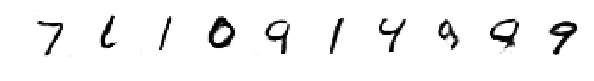

Original Test


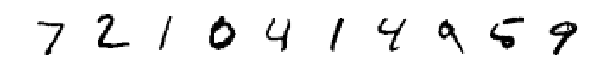

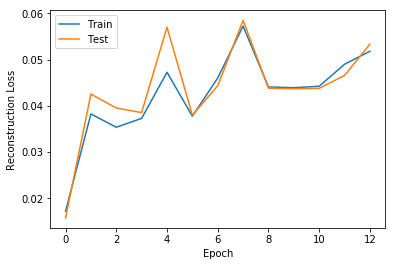

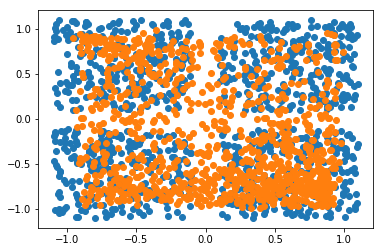

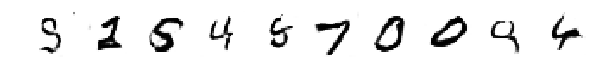

Train reconstruction


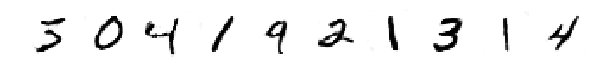

Original Train


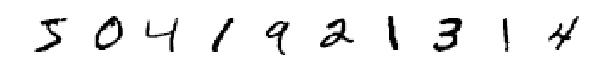

Test reconstruction


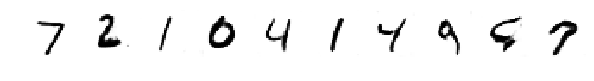

Original Test


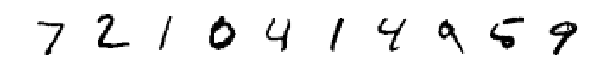

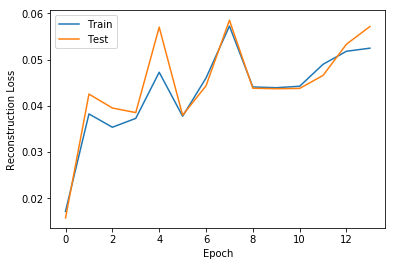

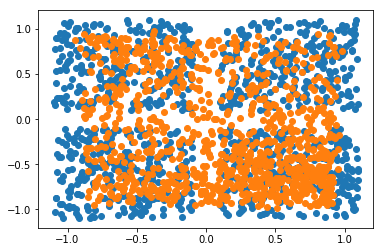

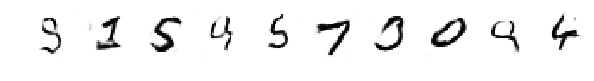

Train reconstruction


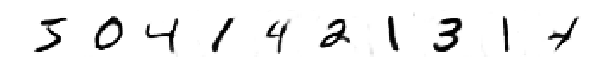

Original Train


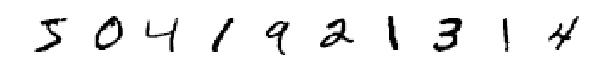

Test reconstruction


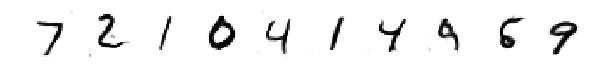

Original Test


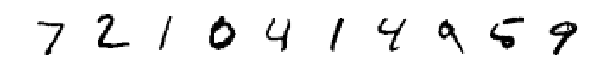

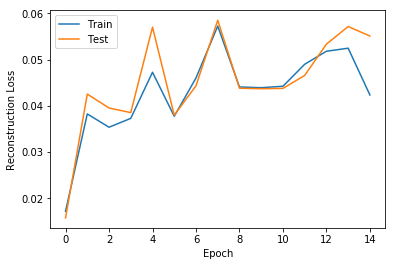

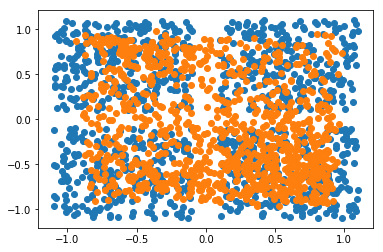

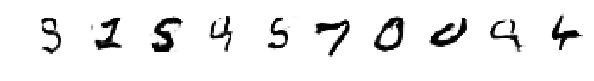

Train reconstruction


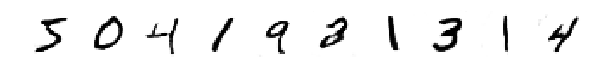

Original Train


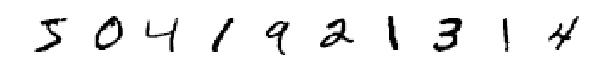

Test reconstruction


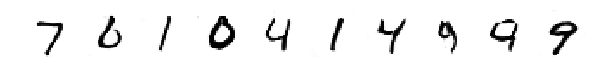

Original Test


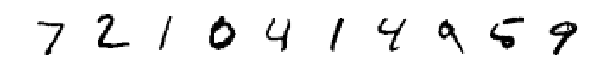

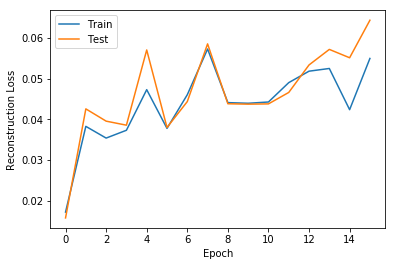

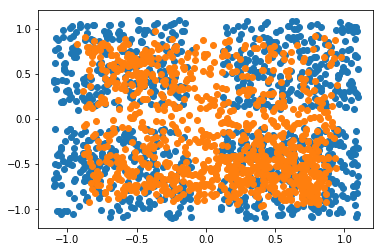

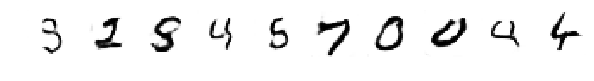

Train reconstruction


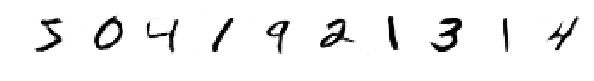

Original Train


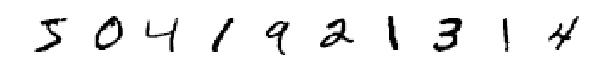

Test reconstruction


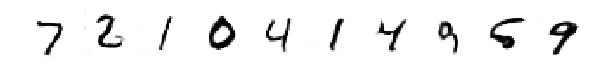

Original Test


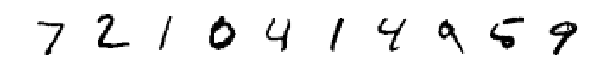

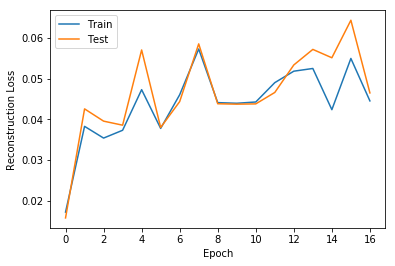

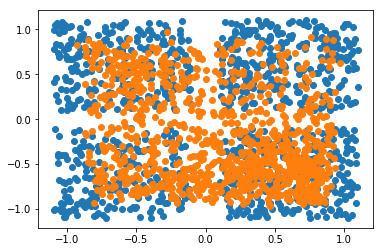

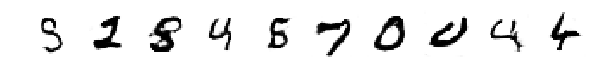

Train reconstruction


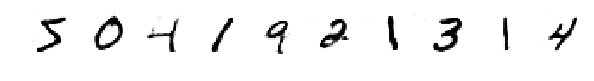

Original Train


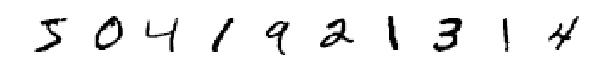

Test reconstruction


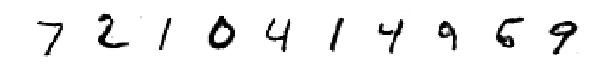

Original Test


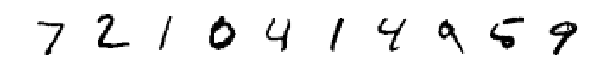

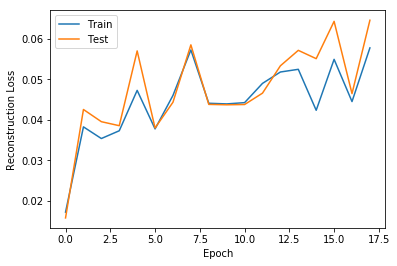

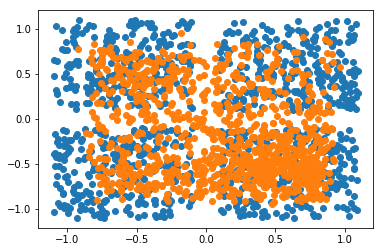

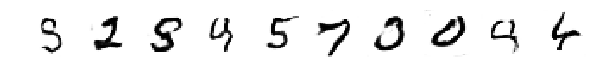

Train reconstruction


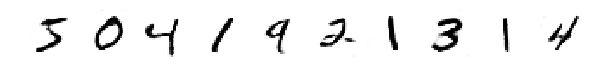

Original Train


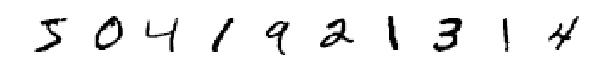

Test reconstruction


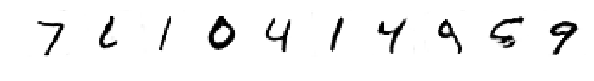

Original Test


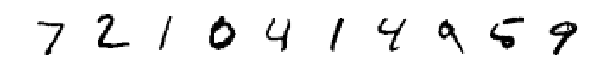

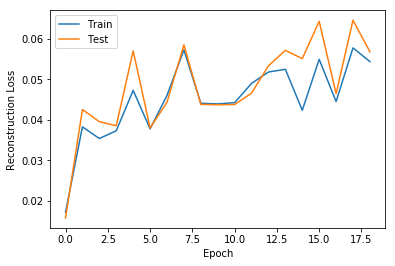

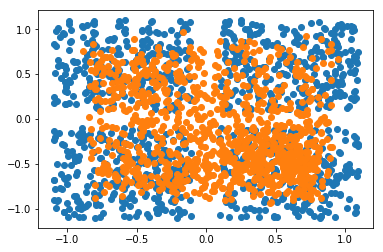

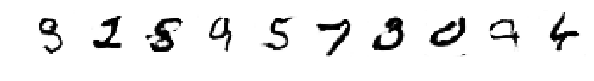

Train reconstruction


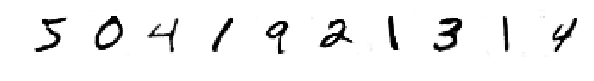

Original Train


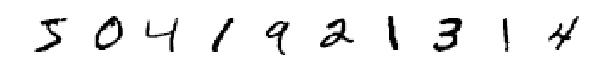

Test reconstruction


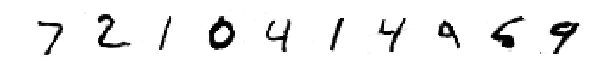

Original Test


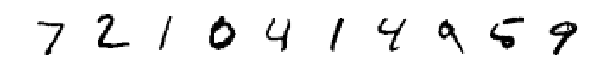

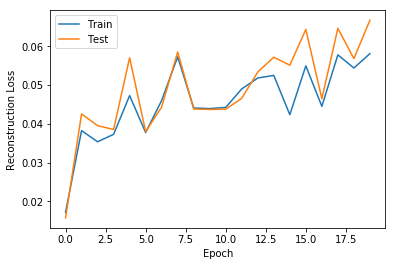

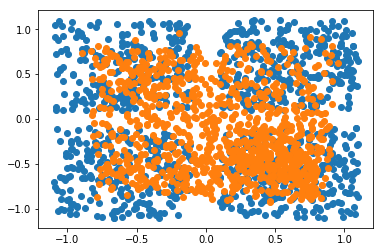

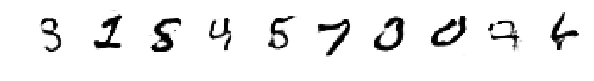

Train reconstruction


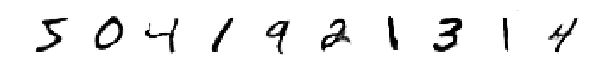

Original Train


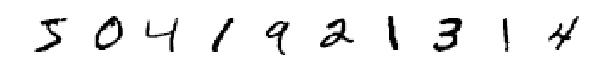

Test reconstruction


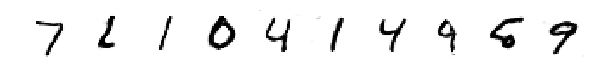

Original Test


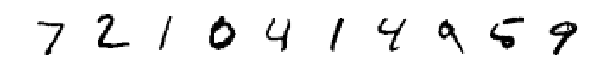

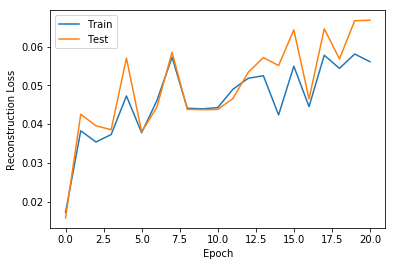

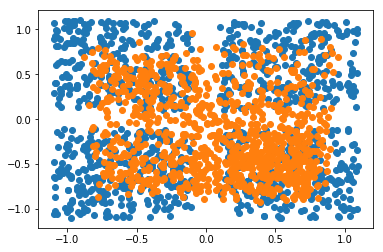

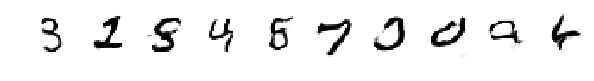

Train reconstruction


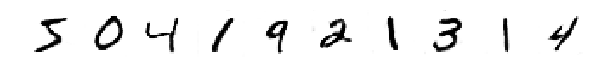

Original Train


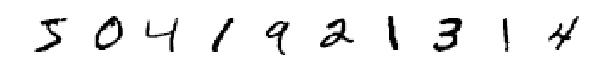

Test reconstruction


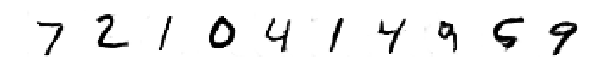

Original Test


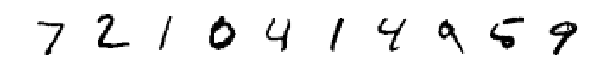

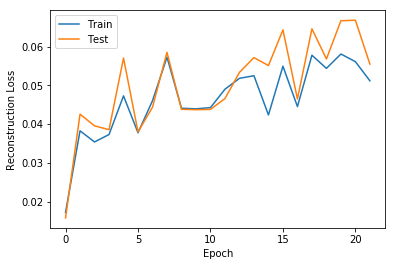

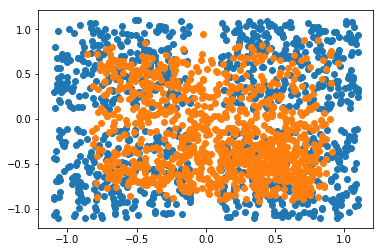

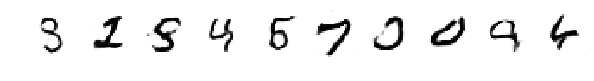

Train reconstruction


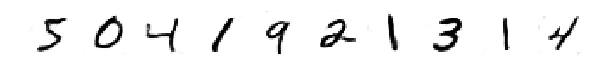

Original Train


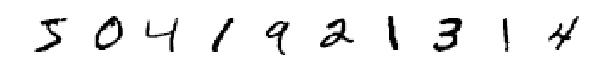

Test reconstruction


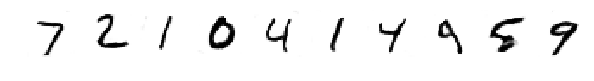

Original Test


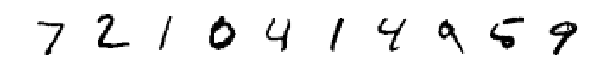

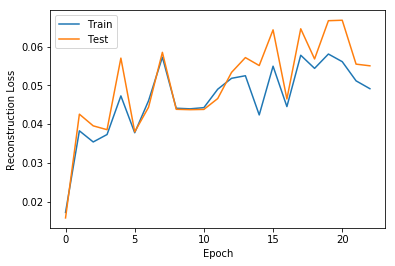

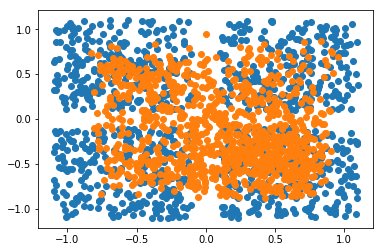

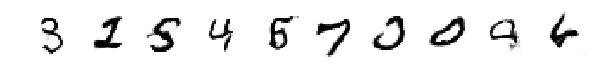

Train reconstruction


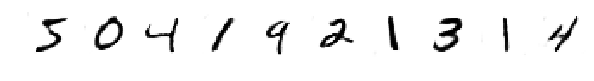

Original Train


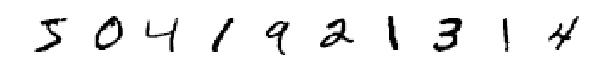

Test reconstruction


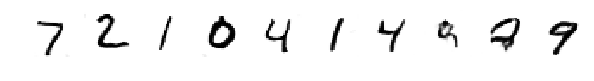

Original Test


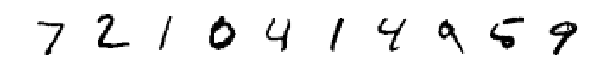

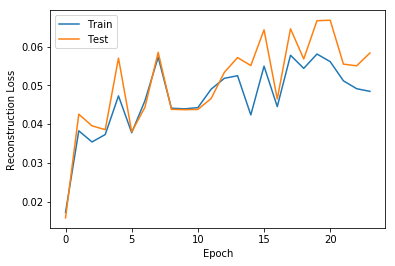

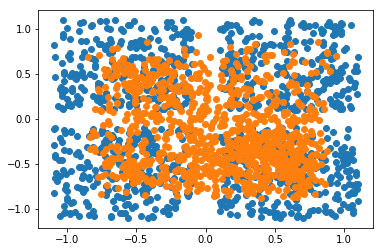

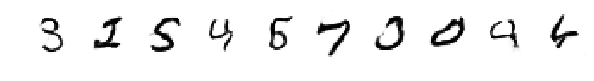

Train reconstruction


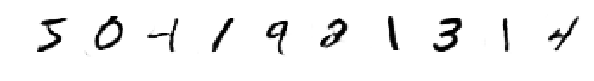

Original Train


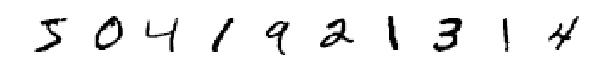

Test reconstruction


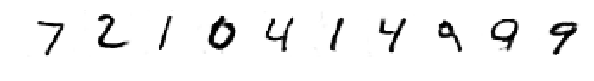

Original Test


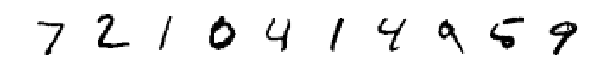

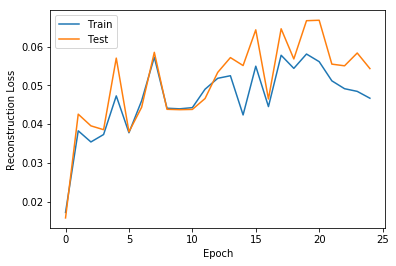

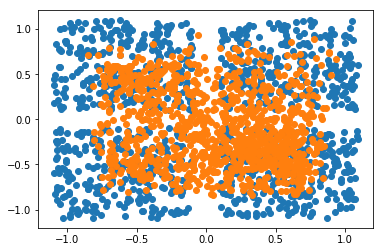

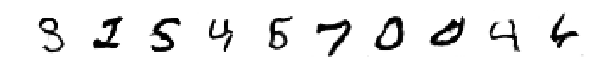

Train reconstruction


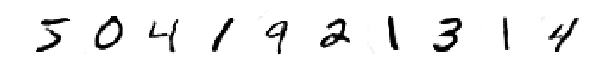

Original Train


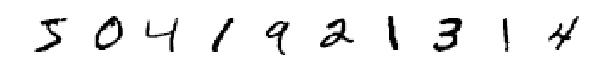

Test reconstruction


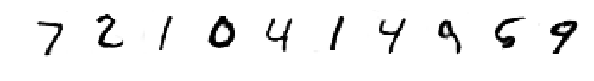

Original Test


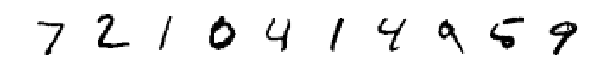

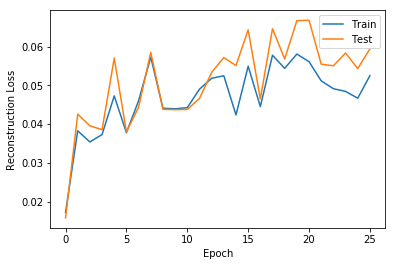

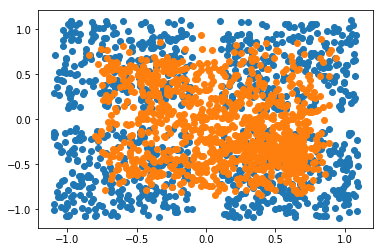

KeyboardInterrupt: ignored

In [5]:
aegan = AutoencodingGAN(Uniform(100), train_decoder=True)

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1),
    (lambda: aegan.save(f"{PROJECT_PATH}/models/ae_gan"), 5)
]

aegan.train(X_train, epochs=30, batch_size=128, callbacks=train_callbacks, d_steps=5)

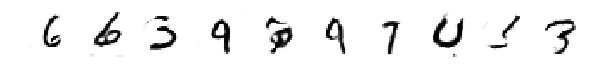

In [4]:
#aegan = AutoencodingGAN(Unconnected(100))
aegan.generator.load_weights(f"{PROJECT_PATH}/models/ae_gan_g.h5")
aegan.discriminator.load_weights(f"{PROJECT_PATH}/models/ae_gan_d.h5")
show(aegan.generate(aegan.prior(10)))

### Fill image patches with the GAN

Manipulated samples


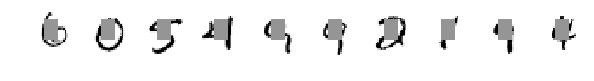

Mask: where was manipulated


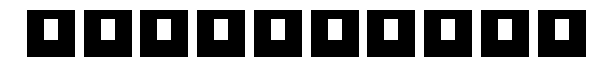

Reconstructed samples


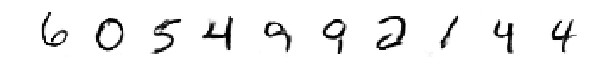

Original samples


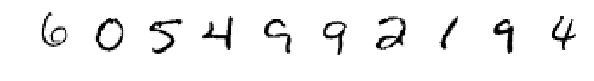

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from scipy.spatial.distance import cdist


class ImageFiller():
    def __init__(self, gan):
        self.gan = gan
        g = gan.generator
        z = Input([gan.prior.d])
        mask = Input([gan.prior.d])
        reals = Input(gan.img_shape)
        fakes = g(z)
        loss = K.square((g.outputs[0]-reals)*mask)
        gradient = K.gradients(loss, g.inputs[0])[0]
        self.iterate = K.function([g.inputs[0], reals, mask], [loss, gradient])

    def fill(self, x, mask):
        # mask: one where we know the pixel, 0 where we don't
        z = self.gan.prior(1000)
        fakes = self.gan.generator.predict(z).reshape([1000, -1])
        x_ = x.reshape([-1, fakes.shape[1]])
        z=z[cdist(fakes, x.reshape([-1, fakes.shape[1]])).argmin(0)]
        lr = z*0+0.1
        momentum = 0.5
        old_gradient = 0
        for i in range(40):
            loss, gradient = self.iterate([z, x, mask])
            gradient = (1-momentum)*gradient + momentum*old_gradient
            old_gradient = gradient
            loss = np.sum(loss, axis=(1, 2, 3))[...,None]
            new_z = z - lr*gradient
            new_z = np.clip(new_z, -1, 1)
            new_loss, _ = self.iterate([new_z, x, mask])
            new_loss = np.sum(new_loss, axis=(1, 2, 3))[...,None]
            z = np.where(new_loss<loss, new_z, z+np.random.normal(0, 0.01, z.shape))
            lr = np.where(new_loss>loss, lr/2, lr*1.1)*0.9
        return self.gan.generator.predict(z)
    
    
samples = np.array(X_test[100:110])
mask = 0*samples + 1
mask[:,6:18, 10:18] = 0
samples*=mask
print('Manipulated samples')
show(samples)
print('Mask: where was manipulated')
show(mask)

filler = ImageFiller(aegan)
filled_samples = filler.fill(samples, mask)
print('Reconstructed samples')
show(filled_samples)
print('Original samples')
show(X_test[100:110])

In [8]:
from tensorflow.keras.models import load_model
classifier = load_model(f"{PROJECT_PATH}/mnist_predictor.h5")


Instructions for updating:
Use tf.cast instead.


### Adversarial Examples in GAN space

I always wanted to check what happens what you create adversarial examples, but in z space. This could help interpretability of neural networks, because it would answer the question "which realistic similar input would you classify different?"

The results are, unfortunately, pretty bad. 

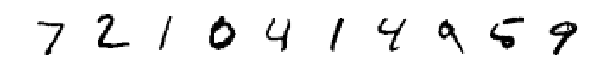

Iteration 0 Accuracy 0.1
Iteration 10 Accuracy 0.3
Iteration 20 Accuracy 0.3
Iteration 30 Accuracy 0.3
Iteration 40 Accuracy 0.3
Iteration 50 Accuracy 0.3
Iteration 60 Accuracy 0.3
Iteration 70 Accuracy 0.3
Iteration 80 Accuracy 0.3
Iteration 90 Accuracy 0.3
Iteration 100 Accuracy 0.3
Iteration 110 Accuracy 0.3
Iteration 120 Accuracy 0.3
Iteration 130 Accuracy 0.3
Iteration 140 Accuracy 0.3
Iteration 150 Accuracy 0.3
Iteration 160 Accuracy 0.3
Iteration 170 Accuracy 0.3
Iteration 180 Accuracy 0.3
Iteration 190 Accuracy 0.3
Iteration 200 Accuracy 0.3
Iteration 210 Accuracy 0.3
Iteration 220 Accuracy 0.3
Iteration 230 Accuracy 0.3
Iteration 240 Accuracy 0.3
Iteration 250 Accuracy 0.3
Iteration 260 Accuracy 0.3
Iteration 270 Accuracy 0.3
Iteration 280 Accuracy 0.3
Iteration 290 Accuracy 0.3
Iteration 300 Accuracy 0.3
Iteration 310 Accuracy 0.3
Iteration 320 Accuracy 0.3
Iteration 330 Accuracy 0.3
Iteration 340 Accuracy 0.3
Iteration 350 Accuracy 0.3
Iteration 360 Accuracy 0.3
Iteration 37

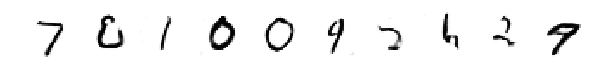

Iteration 0 Accuracy 0.2
Iteration 10 Accuracy 0.4
Iteration 20 Accuracy 0.4
Iteration 30 Accuracy 0.4
Iteration 40 Accuracy 0.4
Iteration 50 Accuracy 0.4
Iteration 60 Accuracy 0.4
Iteration 70 Accuracy 0.4
Iteration 80 Accuracy 0.4
Iteration 90 Accuracy 0.4
Iteration 100 Accuracy 0.4
Iteration 110 Accuracy 0.4
Iteration 120 Accuracy 0.4
Iteration 130 Accuracy 0.4
Iteration 140 Accuracy 0.4
Iteration 150 Accuracy 0.4
Iteration 160 Accuracy 0.4
Iteration 170 Accuracy 0.4
Iteration 180 Accuracy 0.4
Iteration 190 Accuracy 0.4
Iteration 200 Accuracy 0.4
Iteration 210 Accuracy 0.4
Iteration 220 Accuracy 0.4
Iteration 230 Accuracy 0.4
Iteration 240 Accuracy 0.4
Iteration 250 Accuracy 0.4
Iteration 260 Accuracy 0.4
Iteration 270 Accuracy 0.4
Iteration 280 Accuracy 0.4
Iteration 290 Accuracy 0.4
Iteration 300 Accuracy 0.4
Iteration 310 Accuracy 0.4
Iteration 320 Accuracy 0.4
Iteration 330 Accuracy 0.4
Iteration 340 Accuracy 0.4
Iteration 350 Accuracy 0.4
Iteration 360 Accuracy 0.4
Iteration 37

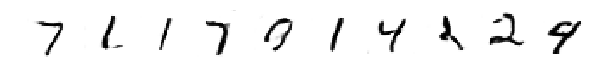

Iteration 0 Accuracy 0.1
Iteration 10 Accuracy 0.3
Iteration 20 Accuracy 0.3
Iteration 30 Accuracy 0.4
Iteration 40 Accuracy 0.5
Iteration 50 Accuracy 0.6
Iteration 60 Accuracy 0.6
Iteration 70 Accuracy 0.6
Iteration 80 Accuracy 0.6
Iteration 90 Accuracy 0.6
Iteration 100 Accuracy 0.6
Iteration 110 Accuracy 0.6
Iteration 120 Accuracy 0.6
Iteration 130 Accuracy 0.6
Iteration 140 Accuracy 0.6
Iteration 150 Accuracy 0.6
Iteration 160 Accuracy 0.6
Iteration 170 Accuracy 0.6
Iteration 180 Accuracy 0.6
Iteration 190 Accuracy 0.6
Iteration 200 Accuracy 0.6
Iteration 210 Accuracy 0.6
Iteration 220 Accuracy 0.6
Iteration 230 Accuracy 0.6
Iteration 240 Accuracy 0.6
Iteration 250 Accuracy 0.6
Iteration 260 Accuracy 0.6
Iteration 270 Accuracy 0.6
Iteration 280 Accuracy 0.6
Iteration 290 Accuracy 0.6
Iteration 300 Accuracy 0.6
Iteration 310 Accuracy 0.6
Iteration 320 Accuracy 0.6
Iteration 330 Accuracy 0.6
Iteration 340 Accuracy 0.6
Iteration 350 Accuracy 0.6
Iteration 360 Accuracy 0.6
Iteration 37

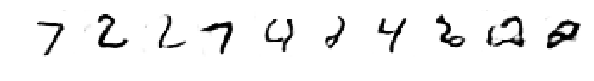

Iteration 0 Accuracy 0.1
Iteration 10 Accuracy 0.2
Iteration 20 Accuracy 0.2
Iteration 30 Accuracy 0.3
Iteration 40 Accuracy 0.3
Iteration 50 Accuracy 0.3
Iteration 60 Accuracy 0.3
Iteration 70 Accuracy 0.3
Iteration 80 Accuracy 0.3
Iteration 90 Accuracy 0.3
Iteration 100 Accuracy 0.3
Iteration 110 Accuracy 0.3
Iteration 120 Accuracy 0.3
Iteration 130 Accuracy 0.3
Iteration 140 Accuracy 0.3
Iteration 150 Accuracy 0.3
Iteration 160 Accuracy 0.3
Iteration 170 Accuracy 0.3
Iteration 180 Accuracy 0.3
Iteration 190 Accuracy 0.3
Iteration 200 Accuracy 0.3
Iteration 210 Accuracy 0.3
Iteration 220 Accuracy 0.3
Iteration 230 Accuracy 0.3
Iteration 240 Accuracy 0.3
Iteration 250 Accuracy 0.3
Iteration 260 Accuracy 0.3
Iteration 270 Accuracy 0.3
Iteration 280 Accuracy 0.3
Iteration 290 Accuracy 0.3
Iteration 300 Accuracy 0.3
Iteration 310 Accuracy 0.3
Iteration 320 Accuracy 0.3
Iteration 330 Accuracy 0.3
Iteration 340 Accuracy 0.3
Iteration 350 Accuracy 0.3
Iteration 360 Accuracy 0.3
Iteration 37

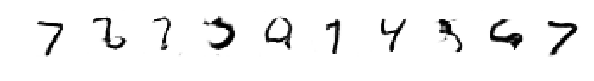

Iteration 0 Accuracy 0.4
Iteration 10 Accuracy 0.5
Iteration 20 Accuracy 0.5
Iteration 30 Accuracy 0.5
Iteration 40 Accuracy 0.5
Iteration 50 Accuracy 0.5
Iteration 60 Accuracy 0.5
Iteration 70 Accuracy 0.5
Iteration 80 Accuracy 0.5
Iteration 90 Accuracy 0.5
Iteration 100 Accuracy 0.5
Iteration 110 Accuracy 0.5
Iteration 120 Accuracy 0.5
Iteration 130 Accuracy 0.5
Iteration 140 Accuracy 0.5
Iteration 150 Accuracy 0.5
Iteration 160 Accuracy 0.5
Iteration 170 Accuracy 0.5
Iteration 180 Accuracy 0.5
Iteration 190 Accuracy 0.5
Iteration 200 Accuracy 0.5
Iteration 210 Accuracy 0.5
Iteration 220 Accuracy 0.5
Iteration 230 Accuracy 0.5
Iteration 240 Accuracy 0.5
Iteration 250 Accuracy 0.5
Iteration 260 Accuracy 0.5
Iteration 270 Accuracy 0.5
Iteration 280 Accuracy 0.5
Iteration 290 Accuracy 0.5
Iteration 300 Accuracy 0.5
Iteration 310 Accuracy 0.5
Iteration 320 Accuracy 0.5
Iteration 330 Accuracy 0.5
Iteration 340 Accuracy 0.5
Iteration 350 Accuracy 0.5
Iteration 360 Accuracy 0.5
Iteration 37

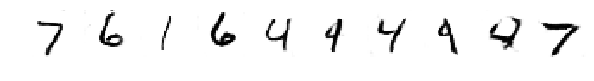

In [34]:
from tensorflow.keras.losses import binary_crossentropy

class AdversarialLatentCodes():
    def __init__(self, gan, classifier):
        self.gan = gan
        self.classifier = classifier
        
        g = gan.generator
        z = Input([gan.prior.d])
        target = Input([10])
        fakes = g(z)
        predictions = classifier(fakes)
        loss = binary_crossentropy(target, predictions)
        gradient = K.gradients(loss, z)[0]
        self.iterate = K.function([z, target], [loss, gradient])

    def change_label(self, x, target):
        # mask: one where we know the pixel, 0 where we don't
        z = self.gan.invert(x)
        lr = z*0+0.2
        momentum = 0.5
        old_gradient = 0
        for i in range(1000):
            loss, gradient = self.iterate([z, target])
            gradient = (1-momentum)*gradient + momentum*old_gradient
            old_gradient = gradient
            loss = loss[...,None]
            new_z = z - lr*gradient
            new_z = np.clip(new_z, -1, 1)
            new_loss, _ = self.iterate([new_z, target])
            new_loss = new_loss[...,None]
            #z = np.where(new_loss<loss, new_z, z+np.random.normal(0, 0.01, z.shape))
            z = new_z
            lr = np.where(new_loss>loss, lr/2, lr*1.1)*0.9
            
            # set learning rate to zero when the classification is now correct
            fakes = self.gan.generator.predict(z)
            predictions = self.classifier.predict(fakes)
            lr[predictions.argmax(1)==target.argmax(1)] = 0
                
        return self.gan.generator.predict(z)
    
samples = X_test[:10]
show(samples)
interpreter = AdversarialLatentCodes(aegan, classifier)
for i in range(5):
    target = np.zeros((10, 10))
    target[:,i] = 1
    modified = interpreter.change_label(samples, target)
    
    show(modified)
    
    

### Comparison of trained encoder vs Gradient Descent Inverter

[autoreload of callbacks failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: 'NoneType' object has no attribute 'name'
]


Distance between found encodings 23.350234151047058
Gradient Based Reconstruction


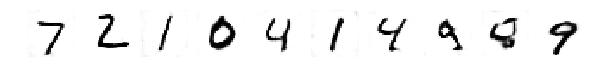

Autoencoder Based Reconstruction


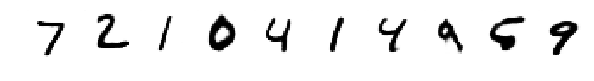

AE  MSE: 0.05514446788045608 
GAN MSE: 0.029878724954635852


In [0]:
# Compare GradientInverser and Encoder

gradient_inverter = GradientInverser(aegan)
samples = X_test[:10]
z_g = gradient_inverter.invert(samples)
z_ae = aegan.encode(samples)
print('Distance between found encodings', np.linalg.norm(z_g - z_ae))
print('Gradient Based Reconstruction')
x_g = aegan.generate(z_g)
show(x_g)
print('Autoencoder Based Reconstruction')
x_ae = aegan.generate(z_ae)
show(x_ae)
print(f"AE  MSE: {np.mean(np.square(x_ae-samples))} \nGAN MSE: {np.mean(np.square(x_g-samples))}")




Interpolation between reconstructions
------------------


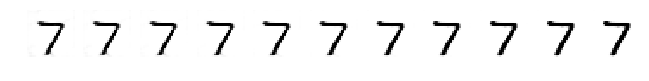

Distance in z/norm(z_g): 1.27
Distance in x/norm(x): 0.18
Distance after applying transformation to next sample 0.4839614553045071


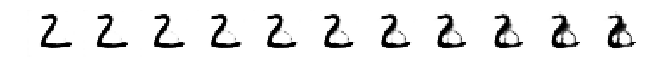

------------------


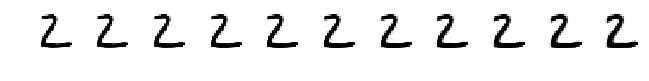

Distance in z/norm(z_g): 0.89
Distance in x/norm(x): 0.30
Distance after applying transformation to next sample 0.6211842953179838


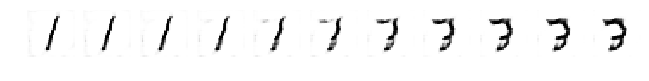

------------------


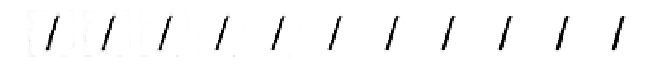

Distance in z/norm(z_g): 1.42
Distance in x/norm(x): 0.12
Distance after applying transformation to next sample 0.5537489646886539


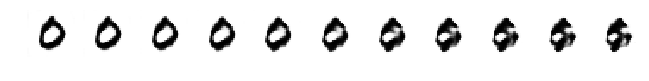

------------------


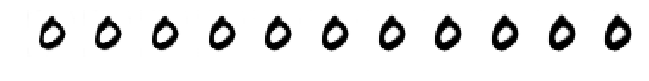

Distance in z/norm(z_g): 1.02
Distance in x/norm(x): 0.29
Distance after applying transformation to next sample 0.5788699017257543


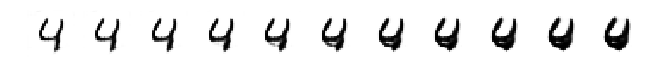

------------------


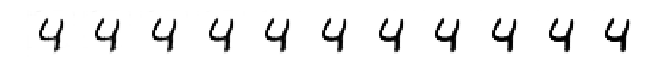

Distance in z/norm(z_g): 0.88
Distance in x/norm(x): 0.20
Distance after applying transformation to next sample 0.303711796027253


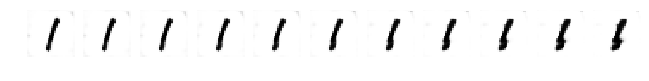

In [0]:
print("Interpolation between reconstructions")

def interpolate(generate, z0, z1):
    b = z0[None,...]
    a = z1[None,...] - b
    x = np.arange(0, 1.05, 0.1)[...,None]
    z = a*x + b
    show(generate(z))

for i in range(5):
    print("------------------")
    interpolate(aegan.generate, z_g[i], z_ae[i])
    print(f"Distance in z/norm(z_g): {np.linalg.norm(z_g[i] - z_ae[i])/np.linalg.norm(z_g[i]):.2f}\n"
         f"Distance in x/norm(x): {np.linalg.norm(x_g[i]-x_ae[i])/np.linalg.norm(samples[i]):.2f}\n"
         "Distance after applying transformation to next sample",
         np.linalg.norm(aegan.generate(z_g[i+1][None,...]) - 
                        aegan.generate((z_g[i+1] -  z_g[i] + z_ae[i])[None,...]))/np.linalg.norm(samples[i+1]))
    interpolate(aegan.generate, z_g[i+1],  z_g[i+1] -  z_g[i] + z_ae[i])
    

### Most discriminative 2D Embedding of x vs z representation

We can find the most discriminative 2D embedding for z or for x space by training a classifier that first projects into the 2D embedding space, and then classifies the labels of our images.

In order to proof the idea, we start with an embedding for x space.

In [0]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten


class Embedding():
    # 2D projection of a distribution that preserves labelinformation
    def __init__(self, x, y, load_from=None, save_to=None):
        try:
            embedding_model = load_model(load_from)
        except Exception as e:
            embedding_model = Sequential()
            embedding_model.add(Flatten(input_shape=x.shape[1:]))
            embedding_model.add(Dense(2))
            embedding_model.add(Dense(2048, activation='relu'))
            embedding_model.add(Dense(10, activation='sigmoid'))
            embedding_model.summary()
            embedding_model.compile(loss='binary_crossentropy', optimizer='sgd',  metrics=['acc'])
            embedding_model.fit(x, y, epochs=8)
            if save_to is not None:
                embedding_model.save(save_to)
        self.to2d = Model(embedding_model.inputs[0], embedding_model.layers[1].output).predict
        self.predict = embedding_model.predict
        
    def plot_true_labels(self, x, y):
        x_2d = self.to2d(x)
        for digit in range(10):
            x_of_digit = x_2d[y.argmax(1)==digit]
            plt.plot(x_of_digit[:,0], x_of_digit[:,1], '.', label=digit)
        plt.title("True labels")
        plt.legend()
        plt.show()
        
    def plot_eval(self, x, y):
        x_2d = self.to2d(x)
        Y_pred = self.predict(x)
        for digit in range(10):
            x_of_digit = x_2d[Y_pred.argmax(1)==digit]
            plt.plot(x_of_digit[:,0], x_of_digit[:,1], '.', label=digit)
        plt.title('All predictions')
        plt.legend()
        plt.show()

        Y_pred = self.predict(x)
        correct = x[Y_pred.argmax(1)==y.argmax(1)]
        correct2d = self.to2d(correct)
        Y_pred = self.predict(correct)
        for digit in range(10):
            x_of_digit = correct2d[Y_pred.argmax(1)==digit]
            plt.plot(x_of_digit[:,0], x_of_digit[:,1], '.', label=digit)
        plt.title('Correct predictions')
        plt.legend()
        plt.show()

        Y_pred = self.predict(x)
        incorrect = x[Y_pred.argmax(1)!=y.argmax(1)]
        incorrect2d = self.to2d(incorrect)
        Y_true = y[Y_pred.argmax(1)!=y.argmax(1)]
        for digit in range(10):
            x_of_digit = incorrect2d[Y_true.argmax(1)==digit]
            plt.plot(x_of_digit[:,0], x_of_digit[:,1], '.', label=digit)
        plt.title('Incorrect predictions')
        plt.legend()
        plt.show()


x_embedding = Embedding(X_train, Y_train, load_from='x_embedding.h5')
x_embedding.plot_true_labels(X_test, Y_test)
x_embedding.plot_eval(X_test, Y_test)

# z = aegan.prior(10000)
# fakes = aegan.generate(z)
# mnist_predictor = load_model(f"{PROJECT_PATH}/mnist_predictor.h5")
# labels = mnist_predictor.predict(fakes)
# z_embedding = Embedding(z, labels, load_from='z_embedding.h5')
# z_embedding.plot_true_labels(z, labels)
# z_embedding.plot_eval(z, labels)

z = aegan.encode(X_train[:10000])
z_embedding = Embedding(z, Y_train[:10000], save_to='z_embedding.h5')
z_embedding.plot_true_labels(z, labels)
z_embedding.plot_eval(z, labels)

In [0]:
(mnist_predictor.predict(X_test).argmax(1) == Y_test.argmax(1)).mean()

0.9917

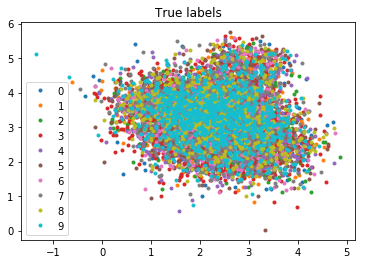

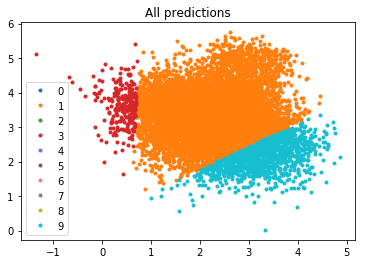

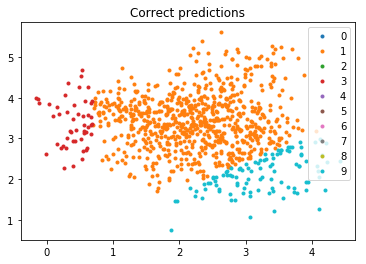

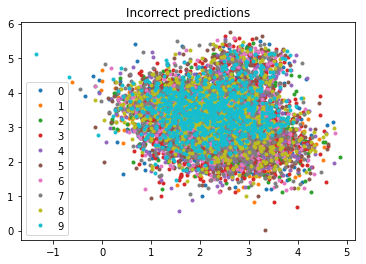

## Train vanilla Autoencoder

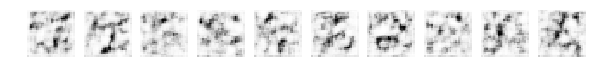

Train reconstruction


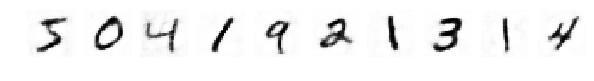

Original Train


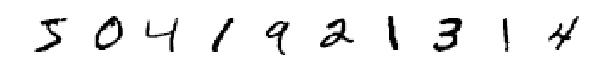

Test reconstruction


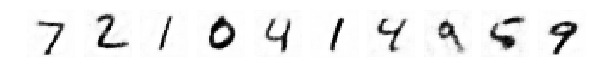

Original Test


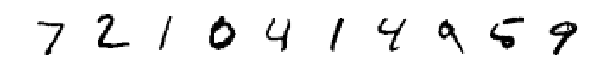

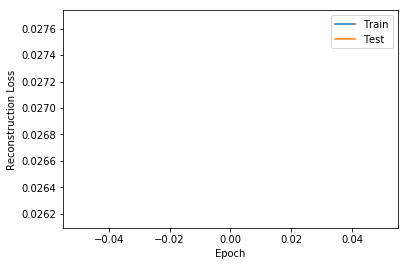

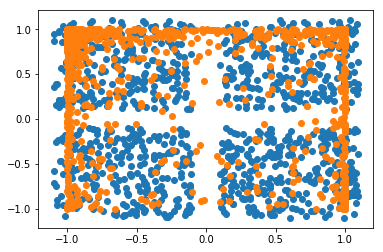

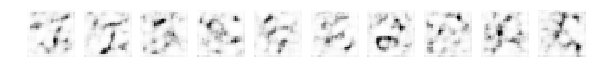

Train reconstruction


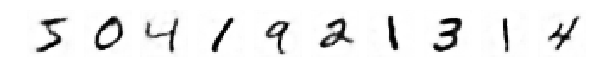

Original Train


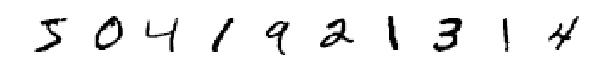

Test reconstruction


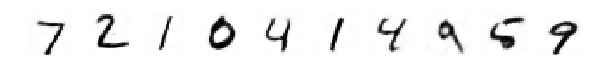

Original Test


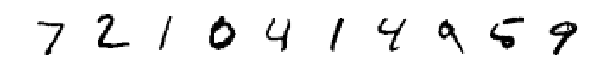

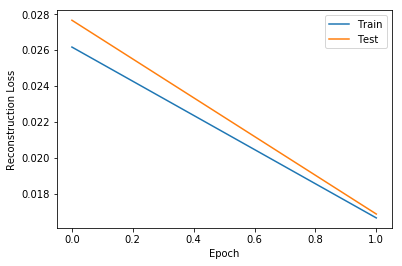

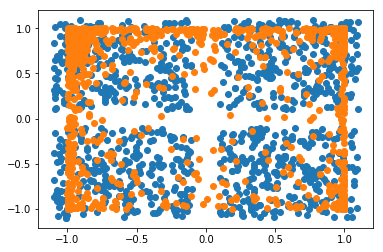

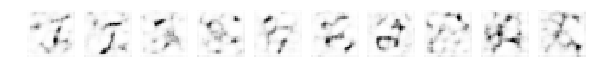

Train reconstruction


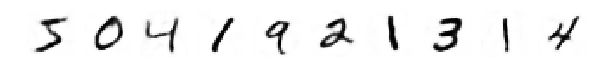

Original Train


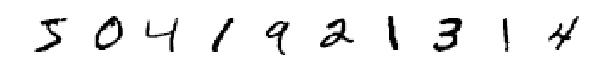

Test reconstruction


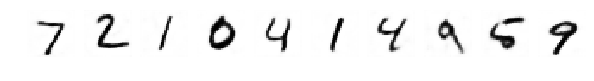

Original Test


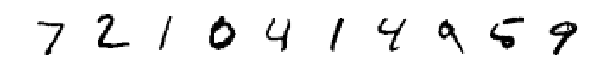

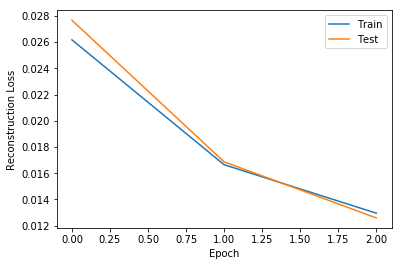

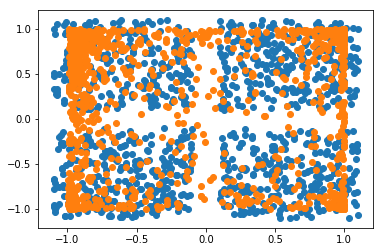

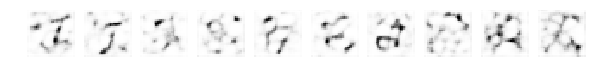

Train reconstruction


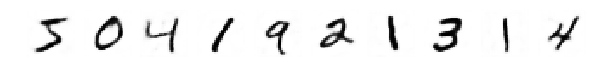

Original Train


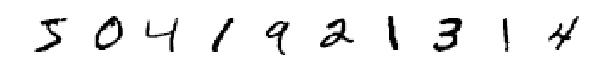

Test reconstruction


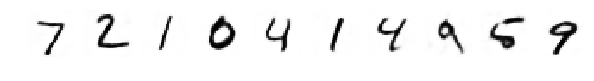

Original Test


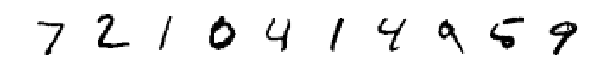

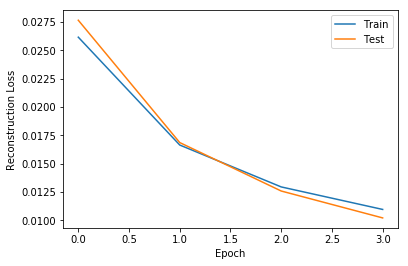

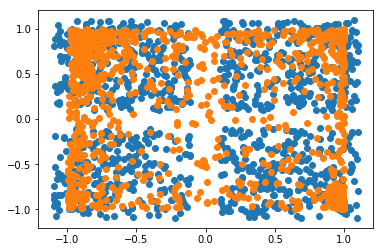

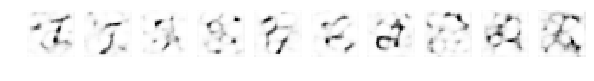

Train reconstruction


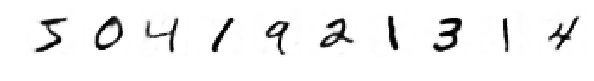

Original Train


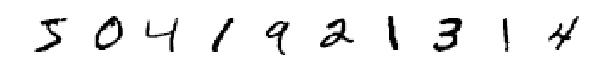

Test reconstruction


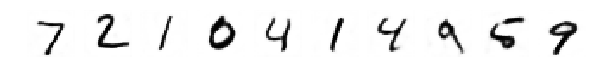

Original Test


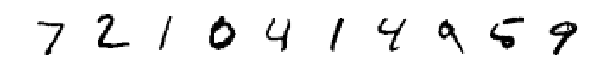

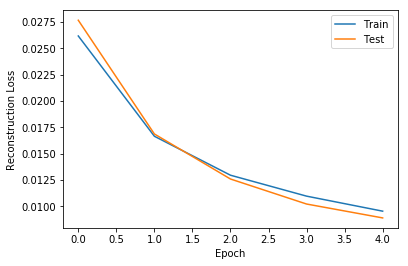

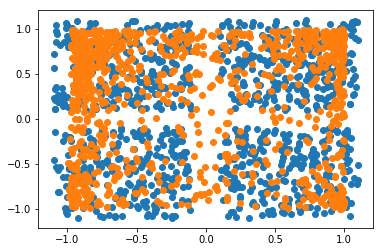

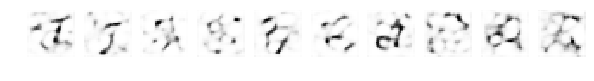

Train reconstruction


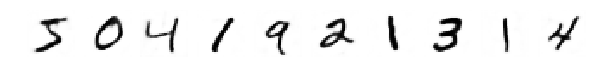

Original Train


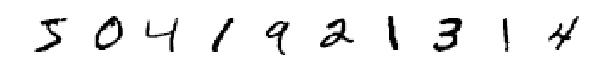

Test reconstruction


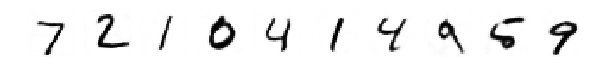

Original Test


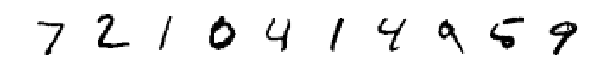

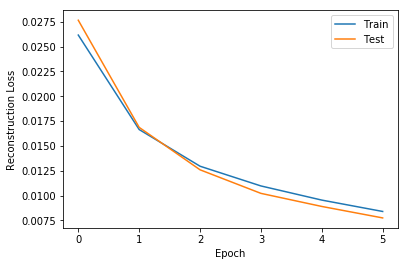

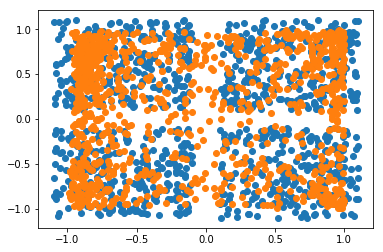

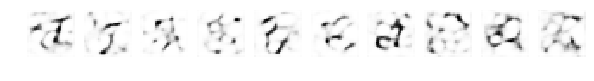

Train reconstruction


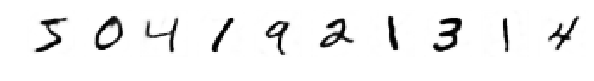

Original Train


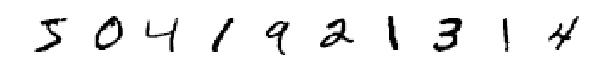

Test reconstruction


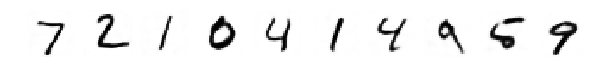

Original Test


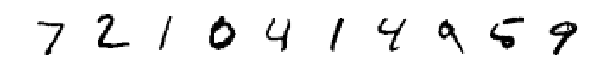

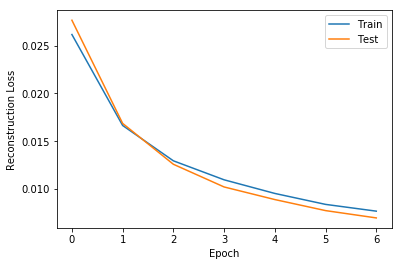

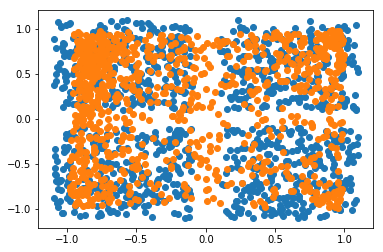

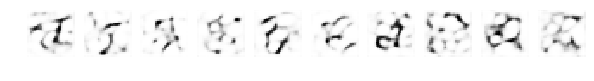

Train reconstruction


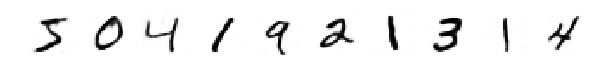

Original Train


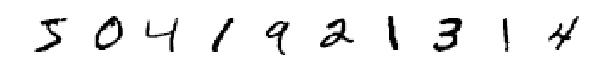

Test reconstruction


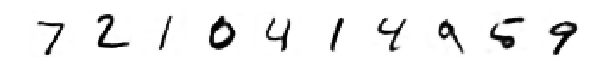

Original Test


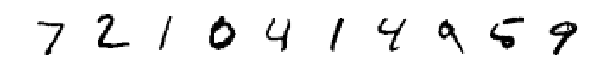

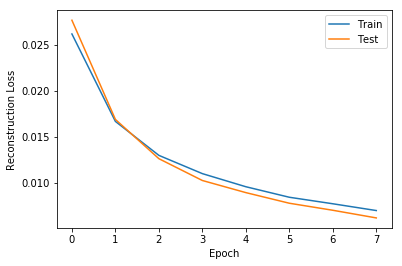

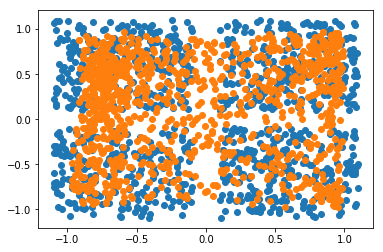

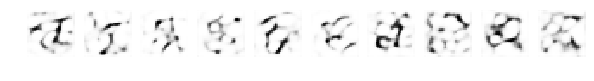

Train reconstruction


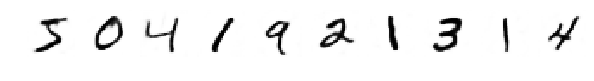

Original Train


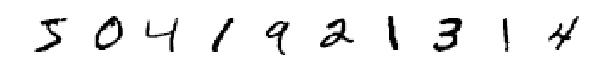

Test reconstruction


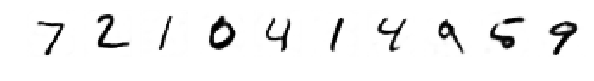

Original Test


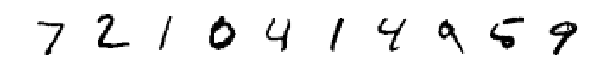

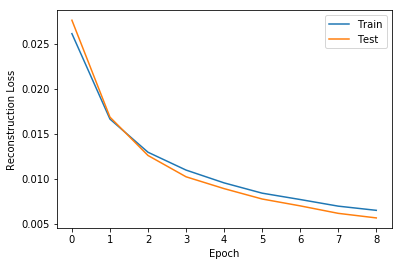

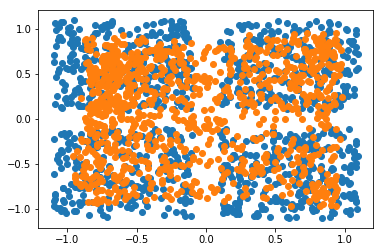

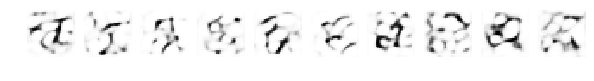

Train reconstruction


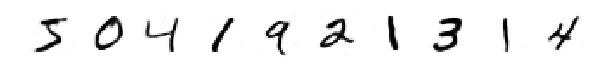

Original Train


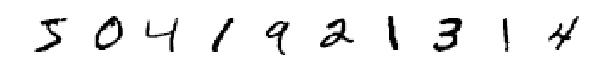

Test reconstruction


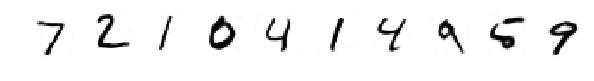

Original Test


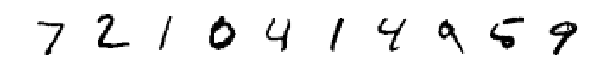

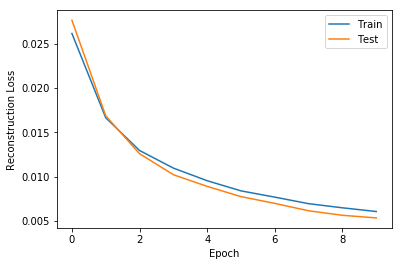

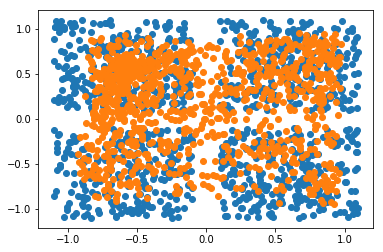

In [0]:
aegan = AutoencodingGAN(gan.Unconnected(100))

period = 10
overfitting_measure = OverfittingCallback(aegan, X_train[:100], X_test[:100], Inverser=aegan.encode)
inverse_distribution = InverseDistributionCallback(aegan, X_test[:1000], inverse=aegan.encode, show_samples=False)

train_callbacks = [
    (callbacks.EvolvingImageCallback(aegan).plot, 1),
    (overfitting_measure.track, 1),
    (overfitting_measure.plot, 1),
    (inverse_distribution.plot, 1)
]

aegan.train(X_train, epochs=10, batch_size=128, callbacks=train_callbacks, d_steps=0, g_steps=0)